In [11]:
# import torch
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet-B5 default input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='train', transform=transform)
val_dataset = datasets.ImageFolder(root='val', transform=transform)
test_dataset = datasets.ImageFolder(root='test', transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

In [12]:
from torchsummary import summary

class CustomEfficientNetB5(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNetB5, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b5')
        self.base_model._fc = nn.Identity()  # Remove the original classification layer

        self.batch_norm = nn.BatchNorm1d(2048)  # EfficientNetB5 has 2048 output features
        self.dense1 = nn.Linear(2048, 1024)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dense2 = nn.Linear(1024, 128)
        self.dropout2 = nn.Dropout(p=0.45)
        self.output_layer = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.base_model(x)
        x = self.batch_norm(x)
        x = torch.relu(self.dense1(x))
        x = self.dropout1(x)
        x = torch.relu(self.dense2(x))
        x = self.dropout2(x)
        x = self.output_layer(x)
        return x

# Initialize the model

num_classes = len(train_dataset.classes)  # Number of classes
classical_model = CustomEfficientNetB5(num_classes).cuda()

# Set up optimizer and loss function
optimizer = optim.Adamax(classical_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
summary(classical_model, input_size=(3, 224, 224))

Loaded pretrained weights for efficientnet-b5
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 48, 112, 112]           1,296
       BatchNorm2d-3         [-1, 48, 112, 112]              96
MemoryEfficientSwish-4         [-1, 48, 112, 112]               0
         ZeroPad2d-5         [-1, 48, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 48, 112, 112]             432
       BatchNorm2d-7         [-1, 48, 112, 112]              96
MemoryEfficientSwish-8         [-1, 48, 112, 112]               0
          Identity-9             [-1, 48, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 12, 1, 1]             588
MemoryEfficientSwish-11             [-1, 12, 1, 1]               0
         Identity-12             [-1, 12, 1, 1]               0
Conv2dStaticSamePadding-13        

In [13]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [14]:
def train_classical_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    device = next(model.parameters()).device
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        
        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    # Save the model
    torch.save(model.state_dict(), 'classical_efficientnet_model.pth')
    
    return train_losses, train_accuracies, val_losses, val_accuracies


In [15]:
classical_train_losses, classical_train_accuracies, classical_val_losses, classical_val_accuracies = train_classical_model(classical_model, train_loader, val_loader, criterion, optimizer)

Epoch 1/10
Training Loss: 0.2172, Training Accuracy: 0.9275
Validation Loss: 0.6477, Validation Accuracy: 0.8030
Epoch 2/10
Training Loss: 0.0685, Training Accuracy: 0.9775
Validation Loss: 0.2159, Validation Accuracy: 0.9200
Epoch 3/10
Training Loss: 0.0411, Training Accuracy: 0.9894
Validation Loss: 0.2001, Validation Accuracy: 0.9260
Epoch 4/10
Training Loss: 0.0346, Training Accuracy: 0.9894
Validation Loss: 0.2245, Validation Accuracy: 0.9325
EarlyStopping counter: 1 out of 5
Epoch 5/10
Training Loss: 0.0315, Training Accuracy: 0.9909
Validation Loss: 0.1702, Validation Accuracy: 0.9470
Epoch 6/10
Training Loss: 0.0338, Training Accuracy: 0.9894
Validation Loss: 0.3066, Validation Accuracy: 0.9175
EarlyStopping counter: 1 out of 5
Epoch 7/10
Training Loss: 0.0293, Training Accuracy: 0.9906
Validation Loss: 0.2436, Validation Accuracy: 0.9300
EarlyStopping counter: 2 out of 5
Epoch 8/10
Training Loss: 0.0181, Training Accuracy: 0.9941
Validation Loss: 0.2664, Validation Accuracy: 0

In [18]:
# Evaluate the model
classical_saved_model = CustomEfficientNetB5(num_classes)
classical_saved_model.load_state_dict(torch.load('classical_efficientnet_model.pth'))
classical_saved_model.to(device)


Loaded pretrained weights for efficientnet-b5


CustomEfficientNetB5(
  (base_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dSta

In [19]:
# Evaluation function
def evaluate_model(model, test_loader, criterion):
    device = next(model.parameters()).device
    model.eval()
    test_loss = 0.0
    corrects = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
    
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = corrects.double() / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    

In [20]:
evaluate_model(classical_saved_model, test_loader, criterion)

Test Loss: 0.2927, Test Accuracy: 0.9062


In [22]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

def load_model(model_path, num_classes):
    model = CustomEfficientNetB5(num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

def predict(model, image_tensor, device):
    with torch.no_grad():
        model = model.to(device)
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        return predicted.item()

# Load the saved model
model_path = 'classical_efficientnet_model.pth'
num_classes = 4  # Replace with the number of classes in your dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = load_model(model_path, num_classes)
model = model.to(device)

# Example usage
image_path = 'test/2_polyps/test_polyps_ (110).jpg'
image_tensor = preprocess_image(image_path)
predicted_class = predict(model, image_tensor, device)

# Map the predicted class index to class name
class_names = ['normal', 'ulcerative_colitis', 'polyps', 'esophagitis']  # Replace with your actual class names
predicted_class_name = class_names[predicted_class]

print(f"Predicted class: {predicted_class_name}")

# If you want to get the probabilities for all classes
def predict_proba(model, image_tensor, device):
    with torch.no_grad():
        model = model.to(device)
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        return probabilities.squeeze().cpu().numpy()

probabilities = predict_proba(classical_saved_model, image_tensor, device)

for class_name, prob in zip(class_names, probabilities):
    print(f"{class_name}: {prob:.4f}")

Loaded pretrained weights for efficientnet-b5
Predicted class: polyps
normal: 0.0000
ulcerative_colitis: 0.0000
polyps: 1.0000
esophagitis: 0.0000


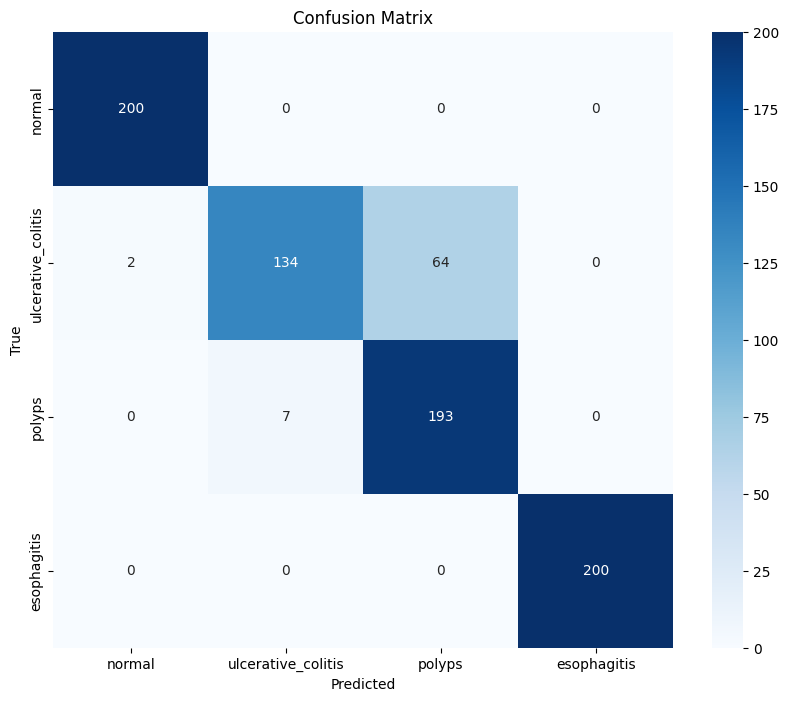

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_loader, class_names):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(classical_saved_model, test_loader, class_names)

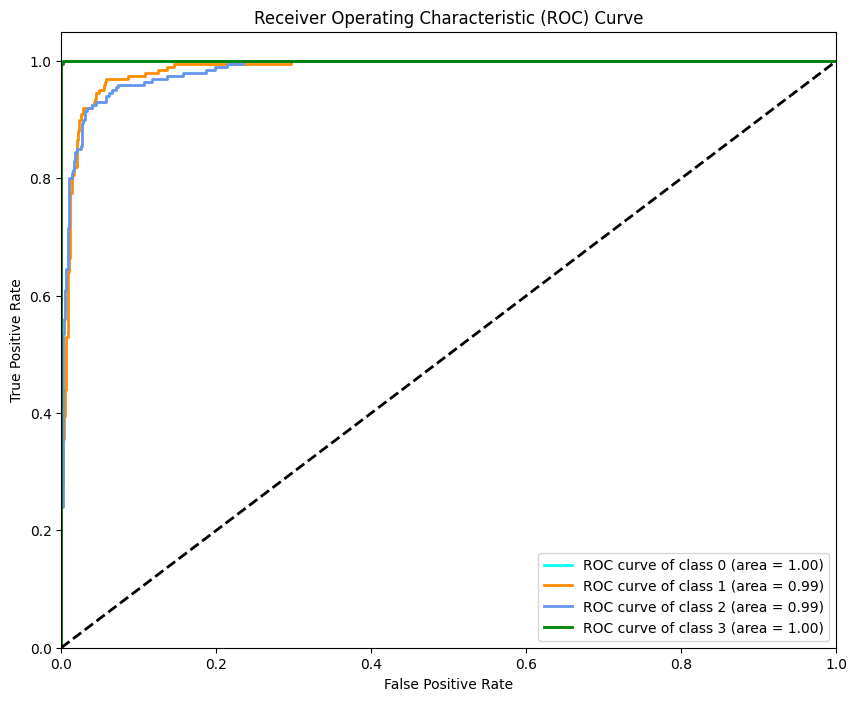

In [24]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc_curve(model, test_loader, num_classes):
    model.eval()
    y_true = []
    y_score = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_score.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
    
    y_true = np.eye(num_classes)[y_true]
    y_score = np.array(y_score)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(classical_saved_model, test_loader, num_classes)